# Interpretability using dog and cat classification

In this notebook, we do a binary classification task between photos of dogs and cats. This then enables us to explore MONAI's interpretability classes:

- `OcclusionSensitivity`,
- `GradCAM++`,
- `SmoothGrad`,
- `GuidedBackpropGrad`, and
- `GuidedBackpropSmoothGrad`.

We use a pre-trained Densenet, which enables us to do very quick training. For brevity, we also don't bother with splitting into training and validation datasets.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/interpretability/cats_and_dogs.ipynb)

In [1]:
from glob import glob
import os
from enum import Enum
import torch
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    DivisiblePadd,
    Lambdad,
    LoadImaged,
    Resized,
    Rotate90d,
    ScaleIntensityd,
)
from monai.networks.utils import eval_mode
from contextlib import nullcontext
from matplotlib import pyplot as plt
from matplotlib import colors
from monai.data import Dataset, DataLoader
from monai.networks.nets import DenseNet121
from monai.data.utils import pad_list_data_collate
from random import shuffle
import numpy as np
from tqdm.notebook import tqdm, trange
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from monai.visualize import (
    GradCAMpp,
    OcclusionSensitivity,
    SmoothGrad,
    GuidedBackpropGrad,
    GuidedBackpropSmoothGrad,
)
from monai.utils import set_determinism
from monai.apps import download_and_extract
from urllib.request import urlretrieve
import tempfile

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_determinism(0)

# Download and extract data

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
data_path = os.path.join(root_dir, "CatsAndDogs")
# check folder exists and contains 25,000 jpgs total
if len(glob(os.path.join(data_path, "**", "**", "*.jpg"))) < 25000:
    url = "https://download.microsoft.com/download/3/E/1/" + \
        "3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
    md5 = "e137a4507370d942469b6d267a24ea04"
    download_and_extract(url, output_dir=data_path, hash_val=md5)

In [3]:
class Animals(Enum):
    cat = 0
    dog = 1


def remove_non_rgb(data, max_num=None):
    """Some images are grayscale or rgba. For simplicity, remove them."""
    loader = LoadImaged("image")
    out = []
    for i in data:
        im = loader(i)["image"]
        if im.ndim == 3 and im.shape[-1] == 3:
            out.append(i)
        if max_num is not None and len(out) == max_num:
            return out
    return out


def get_data(animal, max_num=None):
    files = glob(os.path.join(data_path, "PetImages", animal.name.capitalize(), "*.jpg"))
    data = [{"image": i, "label": animal.value} for i in files]
    shuffle(data)
    data = remove_non_rgb(data, max_num)
    return data


# 500 of each class as this is sufficient
cats, dogs = [get_data(i, max_num=500) for i in Animals]
all_data = cats + dogs
shuffle(all_data)

print(f"Num im cats: {len(cats)}")
print(f"Num im dogs: {len(dogs)}")
print(f"Num images to be used: {len(all_data)}")

Num im cats: 500
Num im dogs: 500
Num images to be used: 1000


In [4]:
batch_size = 20
divisible_factor = 20
transforms = Compose([
    LoadImaged("image"),
    EnsureChannelFirstd("image"),
    ScaleIntensityd("image"),
    Rotate90d("image", k=3),
    DivisiblePadd("image", k=divisible_factor),
])

ds = Dataset(all_data, transforms)
dl = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10,
    collate_fn=pad_list_data_collate,
    drop_last=True,
)

In [5]:
def imshow(data):
    nims = len(data)
    if nims < 6:
        shape = (1, nims)
    else:
        shape = int(np.floor(np.sqrt(nims))), int(np.ceil(np.sqrt(nims)))
    fig, axes = plt.subplots(*shape, figsize=(20, 20))
    axes = np.asarray(axes) if nims == 1 else axes
    for d, ax in zip(data, axes.ravel()):
        # channel last for matplotlib
        im = np.moveaxis(d["image"].detach().cpu().numpy(), 0, -1)
        ax.imshow(im, cmap='gray')
        ax.set_title(Animals(d['label']).name, fontsize=25)
        ax.axis("off")
    plt.show()

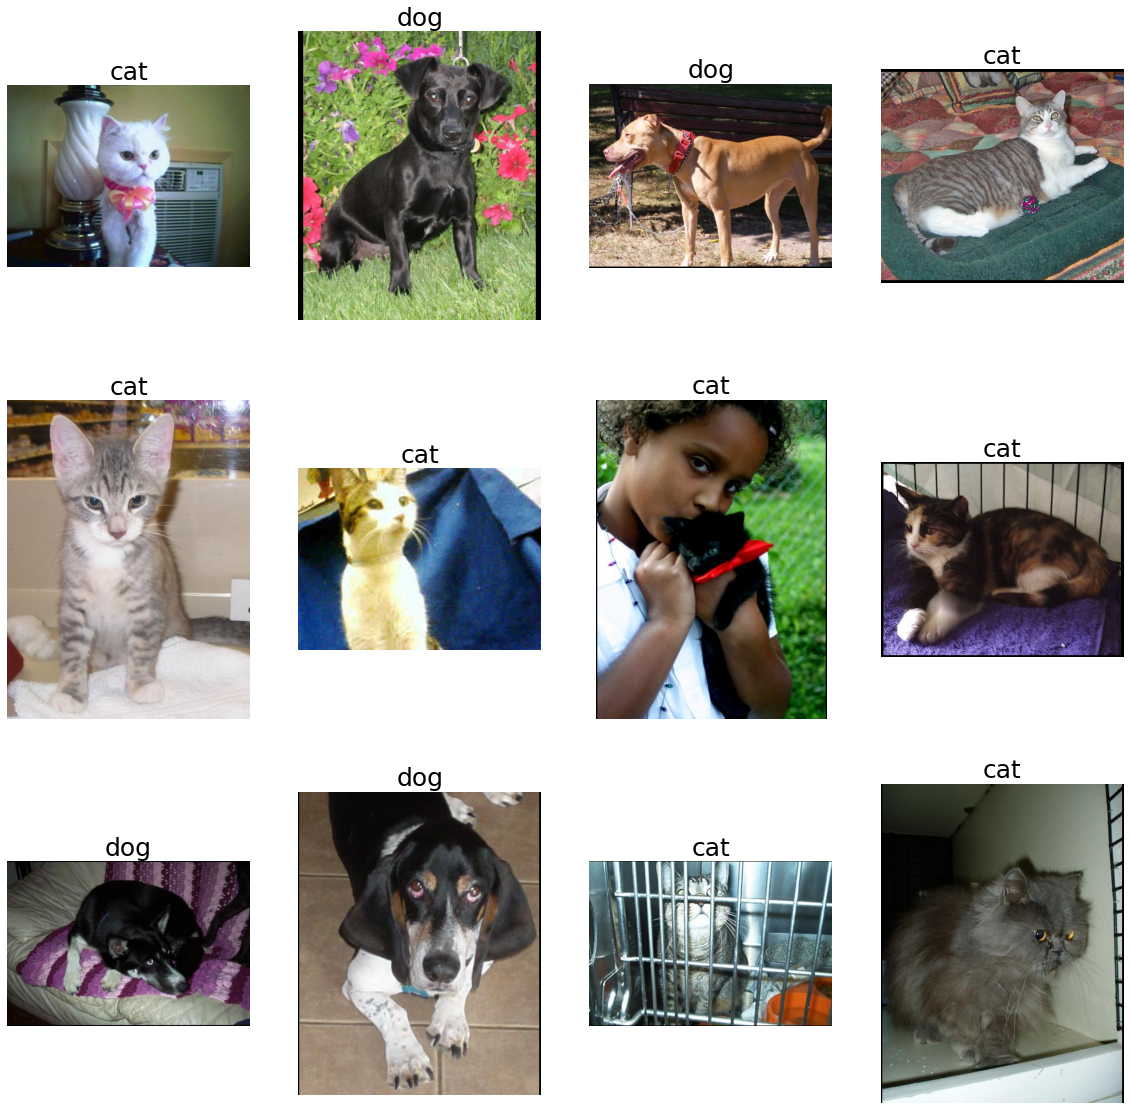

In [6]:
# Random images
rand_idxs = np.random.choice(len(ds), size=12, replace=False)
imshow([ds[i] for i in rand_idxs])

In [7]:
model = DenseNet121(
    spatial_dims=2, in_channels=3, out_channels=2, pretrained=True
).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
use_amp = True
label_dtype = torch.float16 if use_amp else torch.float32
scaler = torch.cuda.amp.GradScaler() if use_amp else None


def criterion(y_pred, y):
    return torch.nn.functional.cross_entropy(y_pred, y, reduction="sum")


def get_num_correct(y_pred, y):
    return (y_pred.argmax(dim=1) == y).sum().item()

In [8]:
max_epochs = 2
for epoch in trange(max_epochs, desc="Epoch"):
    loss, acc = 0, 0
    for data in dl:
        inputs, labels = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast() if use_amp else nullcontext():
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)
            acc += get_num_correct(outputs, labels)
        if use_amp:
            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        loss += train_loss.item()
    loss /= (len(dl) * batch_size)
    acc /= (len(dl) * batch_size)
    print(f"Epoch {epoch+1}, loss: {loss:.3f}, acc: {acc:.4f}")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, loss: 0.604, acc: 0.6210
Epoch 2, loss: 0.313, acc: 0.9390


  0%|          | 0/50 [00:00<?, ?it/s]

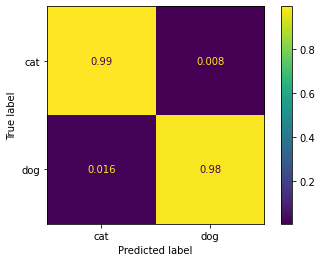

In [9]:
model.eval()
with eval_mode(model):
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for data in tqdm(dl):
        images, labels = data["image"].to(device), data["label"].to(device)
        with torch.cuda.amp.autocast() if use_amp else nullcontext():
            outputs = model(images).detach()
        y_pred = torch.cat([y_pred, outputs], dim=0)
        y = torch.cat([y, labels], dim=0)

    y_pred = y_pred.argmax(dim=1)

    cm = confusion_matrix(
        y.cpu().numpy(),
        y_pred.cpu().numpy(),
        normalize='true',
    )
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[a.name for a in Animals],
    )
    _ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

# Interpretability

Now we compare our different saliency methods. Initially, the resulting can be tricky to decipher.

## Occlusion sensitivity
With occlusion sensitivity we iteratively block off part of the image and then we record the changes in certainty of the inferred class. This means that for instances where the network correctly infers the image type, we expect the certainty to drop as we occlude important parts of the image. Hence, for correct inference, blue parts of the image imply importance.

This is also true when the network **incorrectly** infers the image; blue areas were important in inferring the given class.

## GradCAM
The user chooses a layer of the network that interests them and the gradient is calculated at this point. The chosen layer is typically towards the bottom of the network, as all the features have hopefully been extracted by this point. The images have been downsampled many times, and so the resulting images are linearly upsampled to match the size of the input image. As with occlusion sensitivity, blue parts of the image imply importance in the decision making process.

## VanillaGrad
`VanillaGrad` looks at the gradient of the image after putting it through the network. It is the basis for `SmoothGrad`, `GuidedBackpropGrad`, and `GuidedBackpropSmoothGrad`. For all of these methods, red areas imply importance in the decision making process.

`VanillaGrad` is omitted in this notebook to save space but the user can add it in if interested.

## SmoothGrad
 `SmoothGrad` repeatedly (default=25) adds noise to the input image and performs `VanillaGrad`. The results are then averaged.

## GuidedBackpropGrad and GuidedBackpropSmoothGrad
`GuidedBackpropGrad` and `GuidedBackpropSmoothGrad` extend upon `VanillaGrad` and `SmoothGrad`, respectively. They both store the gradients at certain points of the network, by default tthis is the `ReLU` layers.

In [10]:
# for name, _ in model.named_modules(): print(name)
target_layer = "class_layers.relu"
gradcampp = GradCAMpp(model, target_layers=target_layer)
occ_sens = OcclusionSensitivity(
    model, mask_size=32, n_batch=batch_size, overlap=0.5, verbose=False,
)
smooth_grad = SmoothGrad(model, verbose=False)
guided_vanilla = GuidedBackpropGrad(model)
guided_smooth = GuidedBackpropSmoothGrad(model, verbose=False)

In [11]:
def saliency(model, d):
    ims = []
    titles = []
    log_scales = []

    img = torch.as_tensor(d["image"])[None].to(device)
    pred_logits = model(img)
    pred_label = pred_logits.argmax(dim=1).item()
    pred_prob = int(torch.nn.functional.softmax(pred_logits, dim=1)[0, pred_label].item() * 100)
    # Image
    ims.append(torch.moveaxis(img, 1, -1))
    titles.append(f"Pred: {Animals(pred_label).name} ({pred_prob}%)")
    log_scales.append(False)

    # Occlusion sensitivity images
    occ_map, _ = occ_sens(img)
    ims.append(occ_map[0, pred_label][None])
    titles.append("Occ. sens.")
    log_scales.append(False)

    # GradCAM
    res_cam_pp = gradcampp(x=img, class_idx=pred_label)[0]
    ims.append(res_cam_pp)
    titles.append("GradCAMpp")
    log_scales.append(False)

    # other gradient-based approaches
    for method, name in zip(
        (smooth_grad, guided_vanilla, guided_smooth),
        ("Smooth", "GuidedVa", "GuidedSm")
    ):
        out = method(img)
        out = torch.sum(out ** 2, dim=1) ** 0.5  # RGB -> scalar
        ims.append(out)
        titles.append(name)
        log_scales.append(True)

    return ims, titles, log_scales

In [12]:
def add_im(im, title, log_scale, row, col, num_examples):
    ax = axes[row, col] if num_examples > 1 else axes[col]
    if isinstance(im, torch.Tensor):
        im = im.detach().cpu()
    if log_scale:
        im_show = ax.imshow(im[0], cmap='jet', norm=colors.LogNorm())
        title += " log"
    else:
        im_show = ax.imshow(im[0], cmap='jet')
    ax.set_title(title, fontsize=25)
    ax.axis("off")
    if col > 0:
        fig.colorbar(im_show, ax=ax)


def add_row(ims, titles, log_scales, row, axes, num_examples):
    for col, (im, title, log_scale) in enumerate(zip(ims, titles, log_scales)):
        if log_scale and im.min() < 0:
            im -= im.min()
        add_im(im, title, log_scale, row, col, num_examples)

  0%|          | 0/5 [00:00<?, ?it/s]

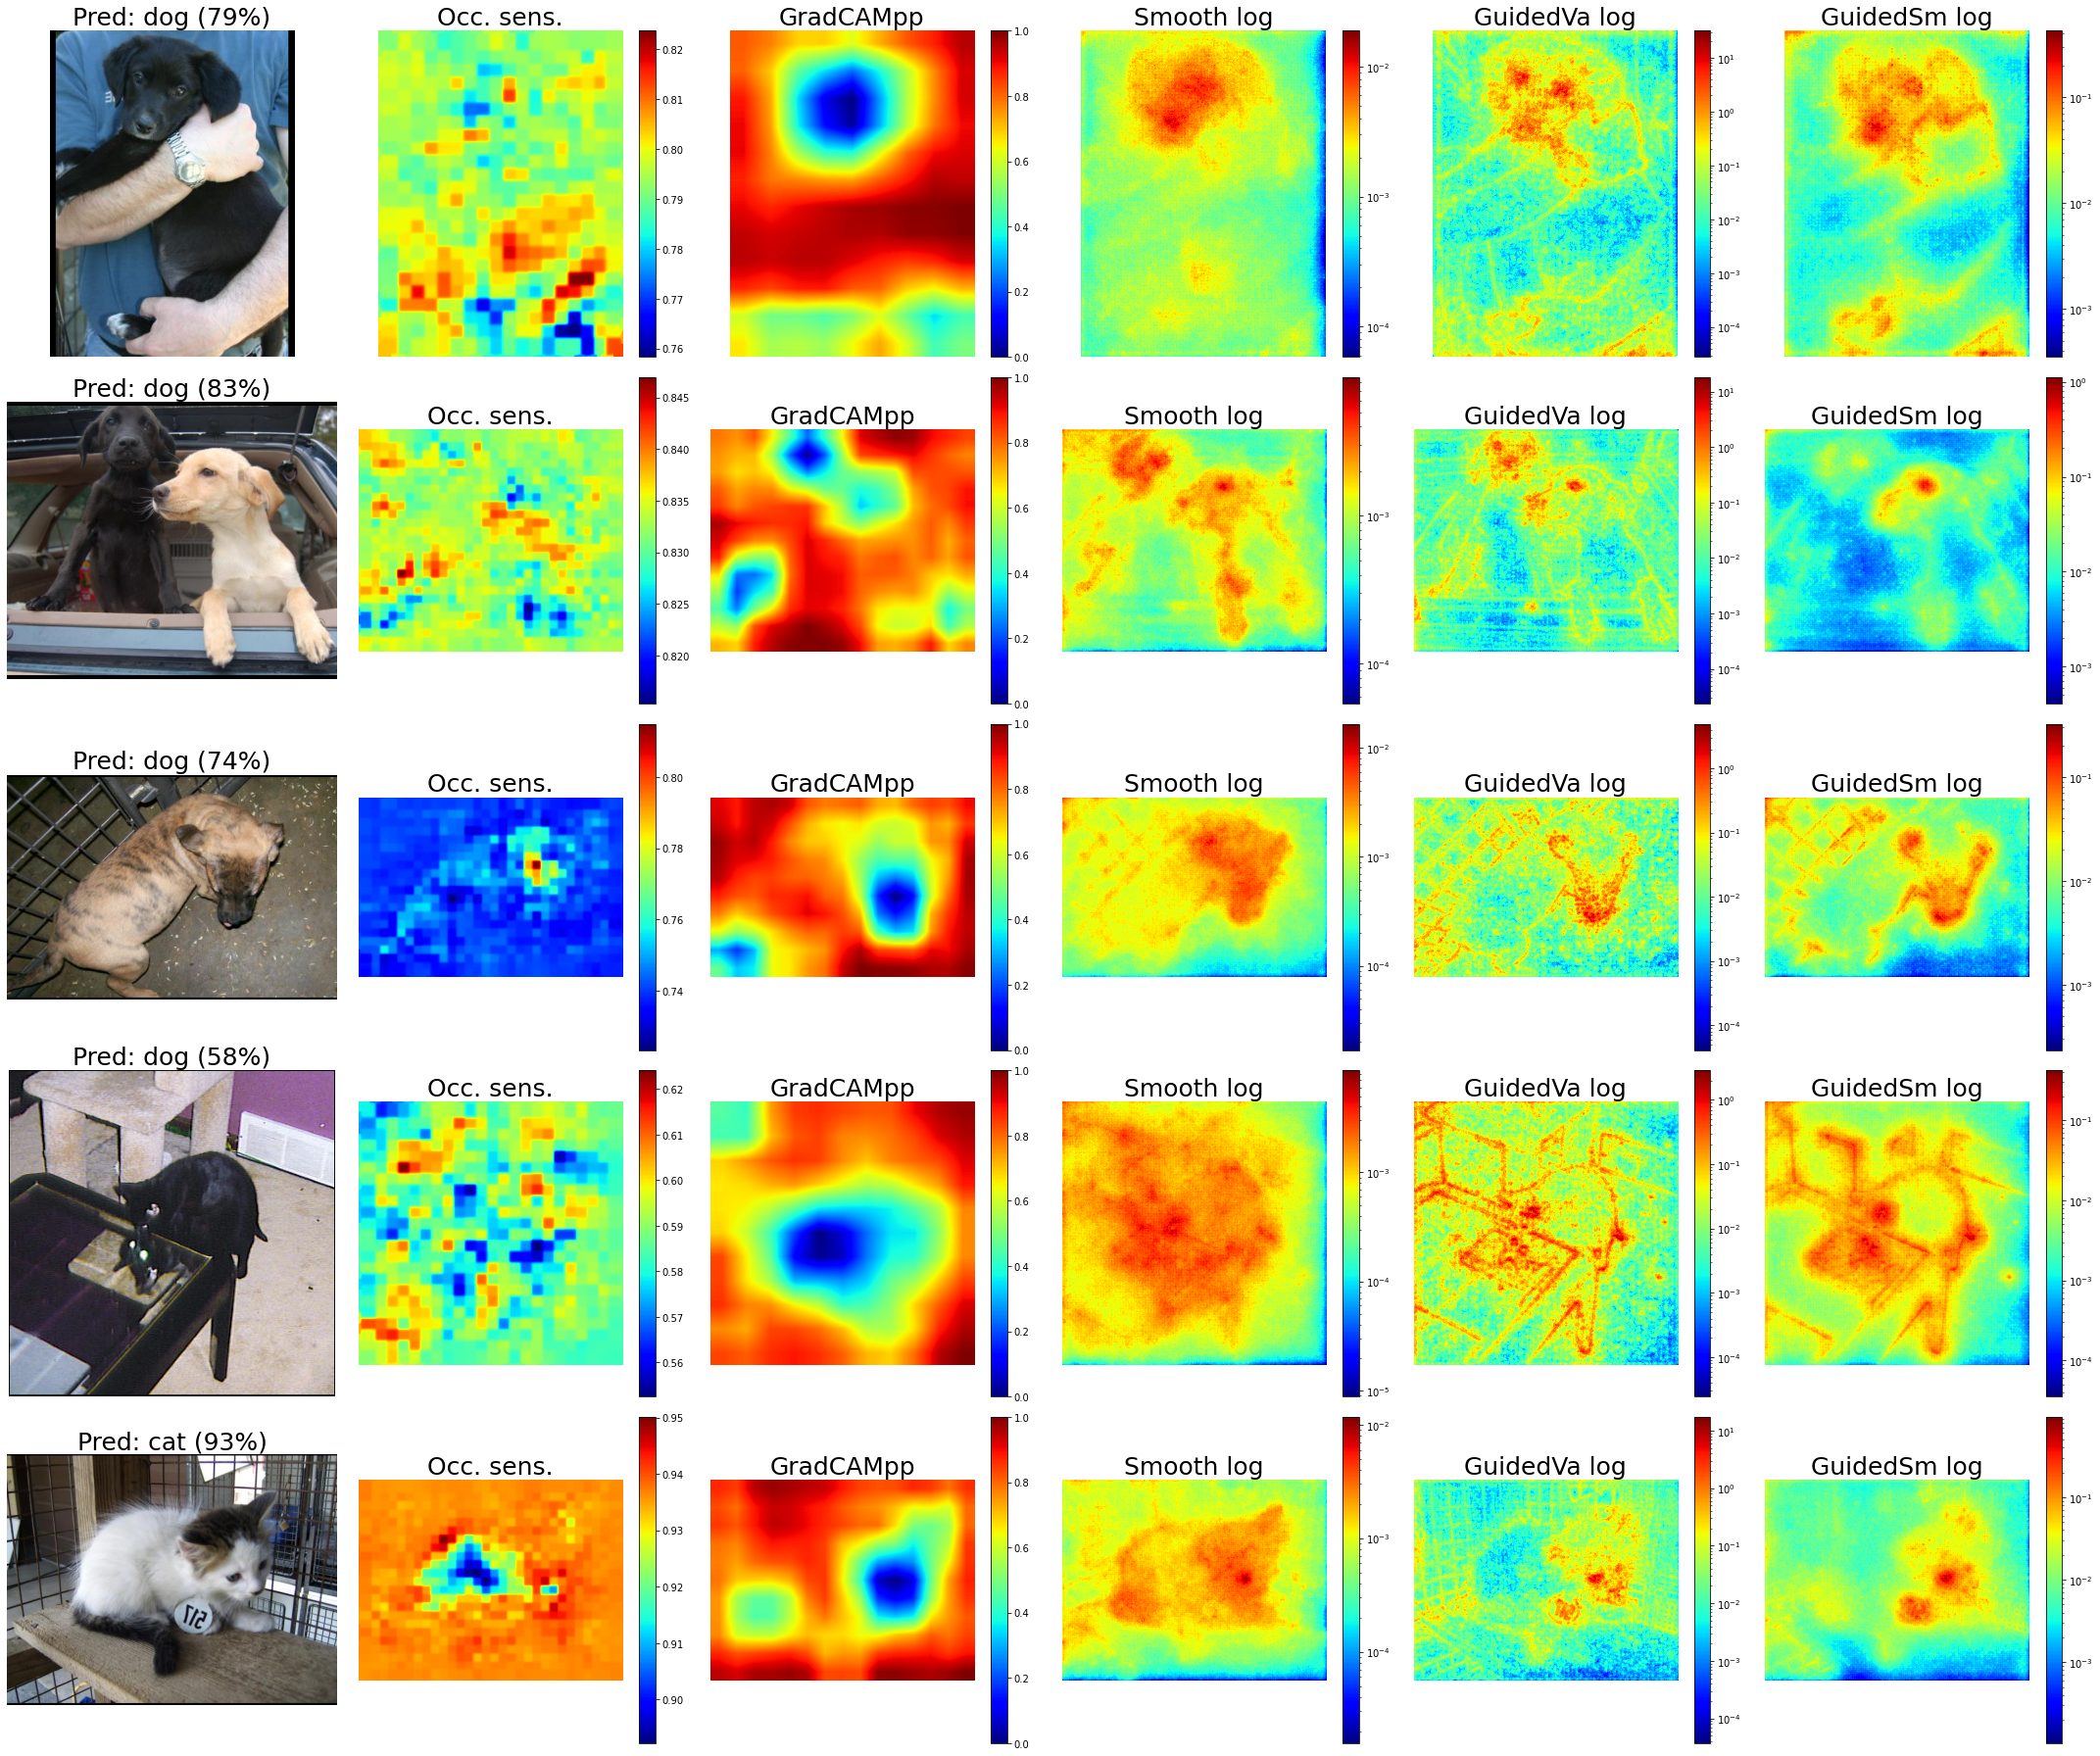

In [13]:
num_examples = 5
rand_data = np.random.choice(ds, replace=False, size=num_examples)
tr = tqdm(rand_data)
for row, d in enumerate(tr):
    tr.set_description(f"img shape: {d['image'].shape[1:]}")
    ims, titles, log_scales = saliency(model, d)
    if row == 0:
        num_cols = len(ims)
        subplot_shape = [num_examples, num_cols]
        figsize = [i * 5 for i in subplot_shape][::-1]
        fig, axes = plt.subplots(*subplot_shape, figsize=figsize, facecolor='white')
    add_row(ims, titles, log_scales, row, axes, num_examples)
plt.tight_layout()

In [14]:
extra_data = [
    {"image": "https://1.bp.blogspot.com/-npE76PYycfo/UGU05ydscwI/AAAAAAAAT3M/OqYkgpDa8o4/s1600/rabbit+23.jpg"},
    {"image": "https://www.catersnews.com/wp-content/uploads/2018/05/3_CATERS_SMILING_FOX_04.jpg"},
    {"image": "https://cdn.britannica.com/55/174255-050-526314B6/brown-Guernsey-cow.jpg"},
    {"image": "https://cdn11.bigcommerce.com/s-ggt0qg2q7p/images/stencil/1280x1280/" +
     "products/516/427/Swimline_9002_46_jumbo_inflatable_beach_ball__23317.1511276116.jpg"},
]


def download_url(url):
    fname = tempfile.NamedTemporaryFile(suffix=".jpg").name
    return urlretrieve(url, fname)[0]


new_transforms = Compose([
    Lambdad("image", download_url),
    transforms,
    Resized("image", (320, 320)),
])

  0%|          | 0/4 [00:00<?, ?it/s]

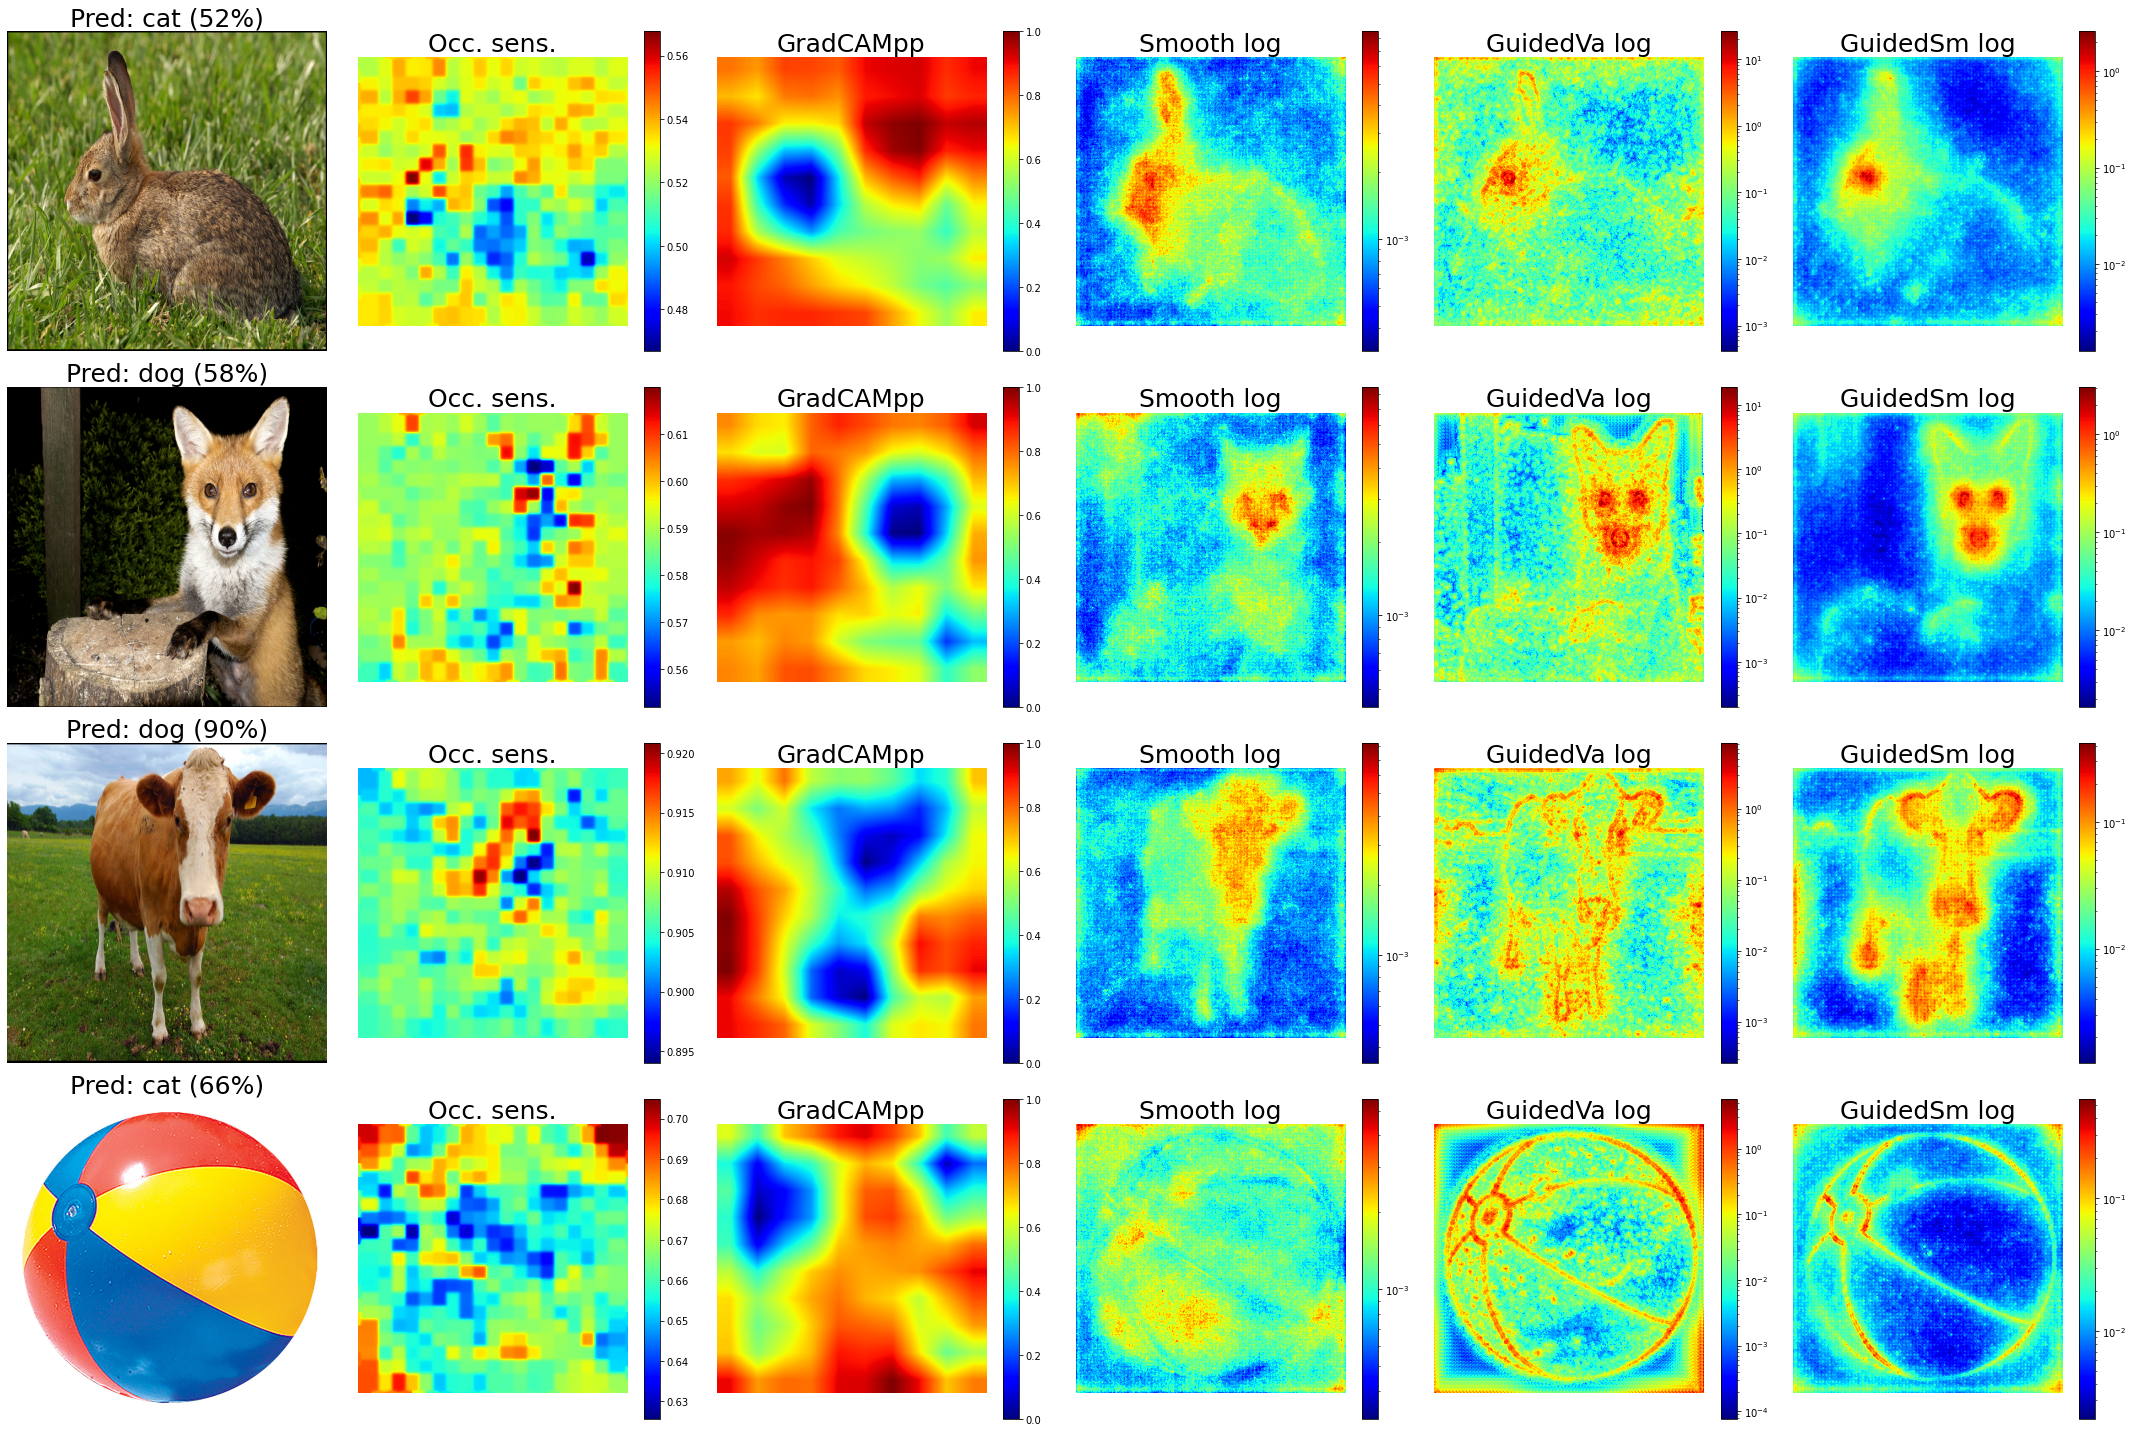

In [15]:
num_examples = len(extra_data)
for row, d in enumerate(tqdm(extra_data)):
    d = new_transforms(d)
    ims, titles, log_scales = saliency(model, d)
    if row == 0:
        num_cols = len(ims)
        subplot_shape = [num_examples, num_cols]
        figsize = [i * 5 for i in subplot_shape][::-1]
        fig, axes = plt.subplots(*subplot_shape, figsize=figsize, facecolor='white')
    add_row(ims, titles, log_scales, row, axes, num_examples)
plt.tight_layout()